# MLP Trial 1

In [ ]:
%cd ..

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats.mstats import winsorize
from src._helper_class import *
from imblearn.pipeline import make_pipeline as imblearn_make_pipeline
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold

import random

In [10]:
# LSTM class
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        param patience: how many epochs to wait before stopping when loss is
            not improving
        param min_delta: minimum difference between new loss and old loss for
        new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        pass
    
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            #print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True
        return

class Net(nn.Module):

    def __init__(self, n_feature, h_1=512, h_2 =256, h_3 = 64, n_out=1):
        super().__init__()
        #self.fc1 = nn.Linear(n_feature, h_1)
        #self.fc2 = nn.Linear(h_1, h_2)
        #self.fc3 = nn.Linear(h_2, n_out)
        #self.SELU = nn.SELU()
        #self.dropout = nn.Dropout(0.5)
        self.layers = nn.Sequential(
                  nn.Linear(n_feature, h_1),
                  nn.SELU(),
                  nn.Dropout(0.5),
                  nn.Linear(h_1, h_2),
                  nn.SELU(),
                  nn.Dropout(0.5),
                  nn.Linear(h_2, h_3),
                  nn.SELU(),
                  nn.Linear(h_3, n_out)
                )

    def forward(self, x):
        #x = self.fc1(x)
        #x = self.SELU(x)
        #x = self.dropout(x)
        #x = self.fc2(x)
        #x = self.SELU(x)
        #x = self.fc3(x)

        return self.layers(x)



In [11]:
def get_default_device():
    # return: device and use_cuda
    if torch.cuda.is_available():
        return torch.device("cuda"), True
    else:
        return torch.device("cpu"), False

def create_X_Y(train_data, train_label, test_data, data_pipeline, city):
    """
    - load training data, test data, test_data
    - filter by city name
    - Apply data pipeline to create modeing dataset
    """
    
    # prepare train features
    train_data = train_data.loc[train_data["city"] == city,:].copy()
    train_data.reset_index(drop = True, inplace = True)
    X = train_data.drop(columns = ["city"])
    
    # prepare train labels
    Y = train_label.loc[train_label["city"] == city,:].copy()
    Y.reset_index(drop = True, inplace = True)
    Y = Y["total_cases"]
    
    # prepare test features
    test_data = test_data.loc[test_data["city"] == city,:].copy()
    test_data.reset_index(drop = True, inplace = True)
    X_test = test_data.drop(columns = ["city"])
    
    # Apply pipelines
    X_train = data_pipeline.fit_transform(X, Y)
    Y_train = Y.to_numpy()
    # Apply pipelines
    X_test = data_pipeline.transform(X_test)
    
    return X_train, Y_train, X_test


def create_data_iter(batch_size, features, labels):
    t_features = torch.tensor(features)
    t_labels = torch.tensor(labels)
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield t_features[batch_indices], t_labels[batch_indices]
                


def MLP_train_eval(epoch, data_iter, val_X, val_y):
    model.train()
    
    train_loss = 0
    for i, (x, y) in enumerate(data_iter):
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad()        
        outputs = model(x)
        loss = criterion(outputs.view(-1), y)
        loss.backward()
        optimizer.step()
        
        train_loss += mae_loss(outputs.view(-1), y)
    
    train_loss /= (i+1)

        
    model.eval()
    with torch.no_grad():
        val_X, val_y = val_X.to(device), val_y.to(device)
        val_outputs = model(val_X.float())       
        val_loss = mae_loss(val_outputs.view(-1), val_y)        
        
    #if epoch % 10 == 0:
        #print('Epoch: {}. train Loss: {}. val loss: {}'.format(epoch, train_loss, val_loss))
        
    return train_loss, val_loss

def MLP_train_only(epoch, data_iter):
    model.train()
    
    train_loss = 0
    for i, (x, y) in enumerate(data_iter):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()        
        outputs = model(x.float())
        loss = criterion(outputs.view(-1), y)
        loss.backward()
        optimizer.step()
        
        train_loss += mae_loss(outputs.view(-1), y)
    
    train_loss /= (i+1)     
        
    #if epoch % 10 == 0:
        #print('Epoch: {}. train Loss: {}'.format(epoch, train_loss))
        
    return train_loss


def MLP_train(batch_size, train_X, train_y, val_X, val_y):
    
    for epoch in range(nums_epochs):
        print("current epoch: ", epoch, end = "\r", flush = True)
        
        data_iter = create_data_iter(batch_size, train_X, train_y)
        
        train_loss, val_loss = MLP_train_eval(epoch, data_iter, val_X, val_y)
        
        earlystopper(val_loss)
        
        if earlystopper.early_stop:
                print('Early stopped at Epoch: {}. train Loss: {}. val loss: {}'.format(epoch, train_loss, val_loss))
                break
                
                
    return epoch - earlystopper.counter
    

In [12]:
# parameters
batch_size = 64
eta = 0.001
nums_epochs = 1000

device, is_gpu = get_default_device()

fit_trasfrom
trasfrom


e:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping6 9 12 13 14 15 16 17 18 19 20 21 22 23 24 25
Early stopped at Epoch: 25. train Loss: 30.590803146362305. val loss: 36.09511947631836
INFO: Early stopping3 4 6 8 9 10 11 13 14 15 16 18 20 21 23 24 25 26 27 28 30 31 32 33 34 35 37 38 39 40 42
Early stopped at Epoch: 42. train Loss: 29.406524658203125. val loss: 38.26822280883789
INFO: Early stopping4 6 7 9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27 28 29 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 58 59
Early stopped at Epoch: 59. train Loss: 29.222503662109375. val loss: 38.69718933105469
INFO: Early stopping2 4 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 49 50 51 52 53 54 55 56 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 124 127 1

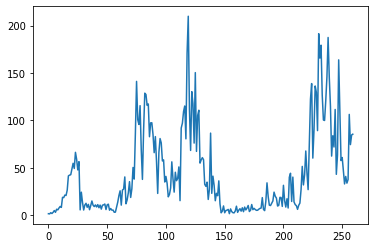

In [13]:
# load data
train_data = pd.read_csv("data/dengue_features_train.csv")
train_label = pd.read_csv("data/dengue_labels_train.csv")
test_data = pd.read_csv("data/dengue_features_test.csv")

sj_data_pipeline = imblearn_make_pipeline(
        Dengue_cat_encoder(),
        Feature_argumentation1(),
        Imputer(impute_mode = 0),
        Feature_argumentation2(mode = 1, max_t_drift = 52),
        Feature_argumentation3(),
        Standardization(),
        PCA(n_components = 348)
)


X_train, Y_train, X_test = create_X_Y(train_data, train_label, test_data, sj_data_pipeline, "sj")

Y_threshold = np.percentile(Y_train, 90)

Y_label = (Y_train > Y_threshold).astype(int)
    
kf = StratifiedKFold(n_splits=5)
    
total_epoch = []
for i, (train_index, va_index) in enumerate(kf.split(X_train, Y_label)):
    temp_X_train = torch.tensor(X_train[train_index])
    temp_X_val = torch.tensor(X_train[va_index])
        
    temp_Y_train = torch.tensor(Y_train[train_index])
    temp_Y_val = torch.tensor(Y_train[va_index])
        
    
        
    model = Net(n_feature = 348).to(device)
    criterion = torch.nn.PoissonNLLLoss()
    mae_loss = torch.nn.L1Loss()

    optimizer = torch.optim.Adam(model.parameters(), 
                             lr=eta)

    earlystopper = EarlyStopping(10, 0.001)
        
    epoch = MLP_train(batch_size,
                      temp_X_train, 
                      temp_Y_train, 
                      temp_X_val, 
                      temp_Y_val)
        
    total_epoch.append(epoch)
        
total_epoch.sort()
mean_epoch = total_epoch[len(total_epoch)//2+1]


model = Net(n_feature = 348).to(device)
criterion = torch.nn.L1Loss()
mae_loss = torch.nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=eta)

print("mean epoch: {}".format(mean_epoch))

for i in range(mean_epoch):
    
    data_iter = create_data_iter(batch_size, 
                             torch.tensor(X_train), 
                             torch.tensor(Y_train))
    train_loss = MLP_train_only(i, data_iter)

print("final train loss: {}".format(train_loss))
    
pred_sj = model(torch.tensor(X_test).float().to(device))
pred_sj = pred_sj.cpu().detach().numpy()

plt.plot(pred_sj)

fit_trasfrom
trasfrom
current epoch:  9

e:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
e:\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


INFO: Early stopping2 13 14
Early stopped at Epoch: 14. train Loss: 6.8307108879089355. val loss: 6.243429183959961
INFO: Early stopping 3 4 6 7 8 9 10 11 12 13 14 15 16 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
Early stopped at Epoch: 36. train Loss: 6.64412784576416. val loss: 6.86693811416626
INFO: Early stopping3 4 5 6 7 8 9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
Early stopped at Epoch: 28. train Loss: 6.729822158813477. val loss: 7.704489231109619
INFO: Early stopping2 3 4 5 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Early stopped at Epoch: 26. train Loss: 6.965624809265137. val loss: 6.065351486206055
INFO: Early stopping3 4 6 7 8 9 10 11 13 14 15 16 17 18 19 20 21 22 23 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 47 49
Early stopped at Epoch: 49. train Loss: 6.369382858276367. val loss: 8.111971855163574
mean epoch: 26
final train loss: 2.607862710952759


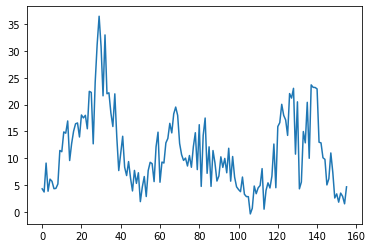

In [14]:
# load data
train_data = pd.read_csv("data/dengue_features_train.csv")
train_label = pd.read_csv("data/dengue_labels_train.csv")
test_data = pd.read_csv("data/dengue_features_test.csv")

iq_data_pipeline = imblearn_make_pipeline(
        Dengue_cat_encoder(),
        Feature_argumentation1(),
        Imputer(impute_mode = 0),
        Feature_argumentation2(mode = 1, max_t_drift = 52),
        Feature_argumentation3(),
        Standardization(),
        PCA(n_components = 248)
)


X_train, Y_train, X_test = create_X_Y(train_data, train_label, test_data, iq_data_pipeline, "iq")

Y_threshold = np.percentile(Y_train, 90)

Y_label = (Y_train > Y_threshold).astype(int)
    
kf = StratifiedKFold(n_splits=5)
    
total_epoch = []
for i, (train_index, va_index) in enumerate(kf.split(X_train, Y_label)):
    temp_X_train = torch.tensor(X_train[train_index])
    temp_X_val = torch.tensor(X_train[va_index])
        
    temp_Y_train = torch.tensor(Y_train[train_index])
    temp_Y_val = torch.tensor(Y_train[va_index])
        
    
        
    model = Net(n_feature = 248).to(device)
    criterion = torch.nn.PoissonNLLLoss()
    mae_loss = torch.nn.L1Loss()

    optimizer = torch.optim.Adam(model.parameters(), 
                             lr=eta)

    earlystopper = EarlyStopping(10, 0.001)
        
    epoch = MLP_train(batch_size,
                      temp_X_train, 
                      temp_Y_train, 
                      temp_X_val, 
                      temp_Y_val)
        
    total_epoch.append(epoch)
        
total_epoch.sort()
mean_epoch = total_epoch[len(total_epoch)//2+1]


model = Net(n_feature = 248).to(device)
criterion = torch.nn.L1Loss()
mae_loss = torch.nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), 
                             lr=eta)

print("mean epoch: {}".format(mean_epoch))

for i in range(mean_epoch):
    
    data_iter = create_data_iter(batch_size, 
                             torch.tensor(X_train), 
                             torch.tensor(Y_train))
    train_loss = MLP_train_only(i, data_iter)

print("final train loss: {}".format(train_loss))
    
pred_iq = model(torch.tensor(X_test).float().to(device))
pred_iq = pred_iq.cpu().detach().numpy()

plt.plot(pred_iq)

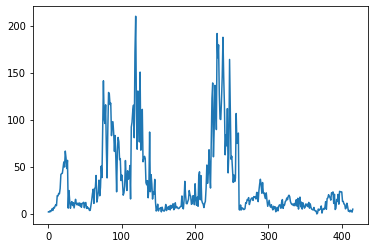

In [15]:
final_result = np.concatenate([pred_sj, pred_iq])
plt.plot(final_result)
submission = pd.read_csv("data/submission_format.csv")
submission["total_cases"] = final_result
submission.to_csv("data/MLP_submission.csv", index = False)